In [9]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

# Ladda dataset
movies_df = pd.read_csv('movies.csv')
ratings_df = pd.read_csv('ratings.csv')
tags_df = pd.read_csv('tags.csv')

In [10]:
# Visa första rader av datan    
display(movies_df.head())
display(ratings_df.head())
display(tags_df.head())

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [11]:
# Få ut mängd filmer, användare, ratings och tags
num_movies = len(movies_df)
num_users = len(ratings_df['userId'].unique())
num_ratings = len(ratings_df)
num_tags = len(tags_df)

print(f"Number of movies: {num_movies}")
print(f"Number of users: {num_users}")
print(f"Number of ratings: {num_ratings}")
print(f"Number of tags: {num_tags}")


Number of movies: 9742
Number of users: 610
Number of ratings: 100836
Number of tags: 3683


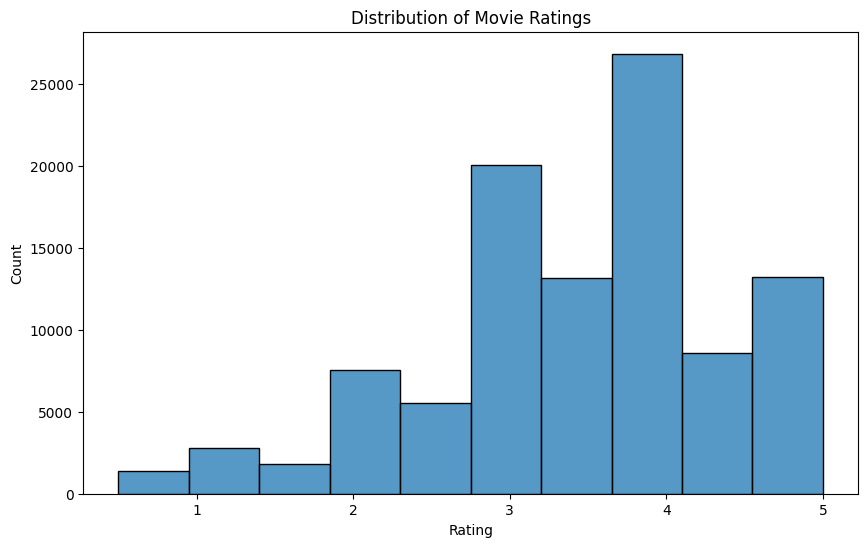

In [12]:
# Visualisera fördelningen av filmbetyg
plt.figure(figsize=(10, 6))
sns.histplot(data=ratings_df, x='rating', bins=10)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

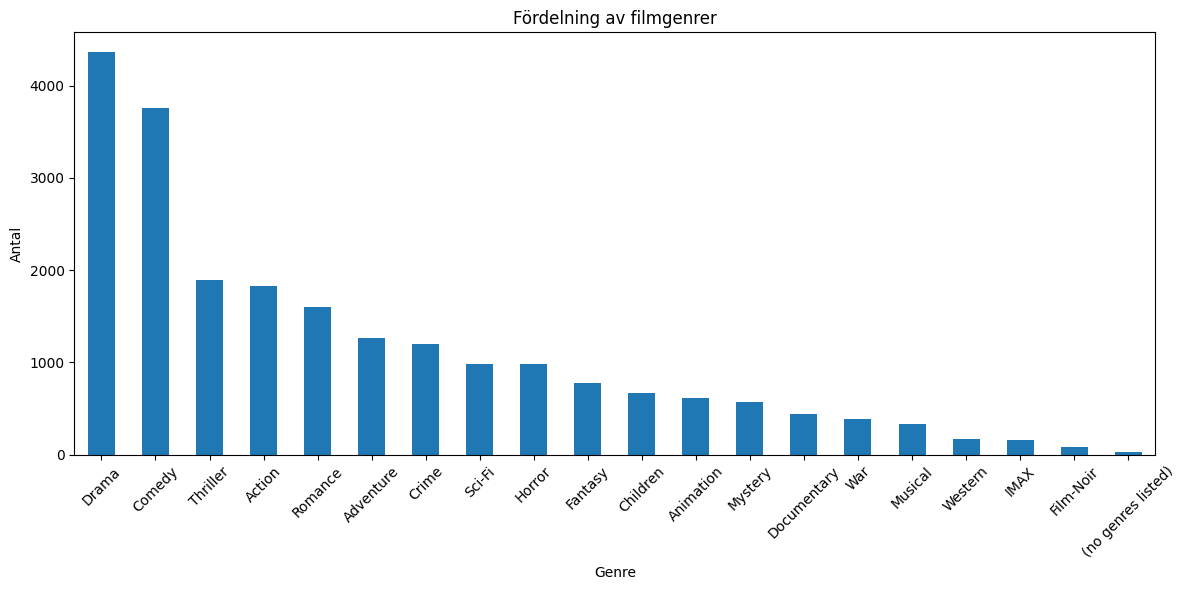

In [13]:
# Skapa en kopia av genredata för att undvika att modifiera originalet
genre_data = movies_df['genres'].str.split('|').copy()
all_genres = [genre for genres in genre_data for genre in genres]
genre_counts = pd.Series(all_genres).value_counts()

plt.figure(figsize=(12, 6))
genre_counts.plot(kind='bar')
plt.title('Fördelning av filmgenrer')
plt.xlabel('Genre')
plt.ylabel('Antal')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
# Steg 1: Hämta mängden filmer som har betyg
rated_movies = ratings_df['movieId'].unique()

# Steg 2: Filtrera filmer för att endast inkludera de med betyg
movies_subset = movies_df[movies_df['movieId'].isin(rated_movies)].copy()
movies_subset = movies_subset.reset_index(drop=True)

# Steg 3: Skapa användare-film-matris för kollaborativ filtrering
user_movie_matrix = ratings_df.pivot(
    index='userId',
    columns='movieId',
    values='rating'
).fillna(0)


In [15]:
# Beräkna likhetsmatris för kollaborativ filtrering
collab_movie_similarity = cosine_similarity(user_movie_matrix.T)

# Steg 4: Förbered taggdata för innehållsbaserad filtrering
tags_df['tag'] = tags_df['tag'].fillna('')
tag_data = tags_df.groupby('movieId')['tag'].apply(lambda x: ' '.join(x)).reset_index()

# Slå ihop taggar med vår filtrerade filmuppsättning
movies_subset = movies_subset.merge(tag_data, on='movieId', how='left')
movies_subset['tag'] = movies_subset['tag'].fillna('')

# Skapa TF-IDF-matris för innehållsbaserad filtrering
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(movies_subset['tag'])
content_movie_similarity = cosine_similarity(tfidf_matrix)

# Nu bör båda matriserna ha samma form/storlek
print(f"Kollaborativ likhetsmatris form: {collab_movie_similarity.shape}")
print(f"Innehållsbaserad likhetsmatris form: {content_movie_similarity.shape}")

Kollaborativ likhetsmatris form: (9724, 9724)
Innehållsbaserad likhetsmatris form: (9724, 9724)


In [16]:

# Beräkna hybridlikhet genom att kombinera båda matriserna
hybrid_movie_similarity = (collab_movie_similarity + content_movie_similarity) / 2

# Skapa en mappning från filmindex till film-ID för delmängden
idx_to_movieid = movies_subset['movieId'].to_dict()
movieid_to_idx = {v: k for k, v in idx_to_movieid.items()}

# Välj en film för att få rekommendationer (t.ex. Toy Story med movieId = 1)
target_movie_id = 1
if target_movie_id in movieid_to_idx:
    target_movie_idx = movieid_to_idx[target_movie_id]
    similar_scores = hybrid_movie_similarity[target_movie_idx]
    similar_movies = list(enumerate(similar_scores))
    similar_movies = sorted(similar_movies, key=lambda x: x[1], reverse=True)
    
    print(f"\nTopp 5 rekommendationer för {movies_subset.loc[target_movie_idx, 'title']}:")
    for idx, score in similar_movies[1:6]:  # Hoppa över den första eftersom det är filmen själv
        print(f"{movies_subset.loc[idx, 'title']}: {score:.4f}")
else:
    print(f"Film-ID {target_movie_id} hittades inte i datasetet med betyg")

# Utvärdera rekommendationsnoggrannhet
# Välj slumpmässiga filmer från vår delmängd för testning
test_indices = np.random.choice(len(movies_subset), min(100, len(movies_subset)), replace=False)
accuracies = []

for idx in test_indices:
    movie_id = movies_subset.loc[idx, 'movieId']
    similar_scores = hybrid_movie_similarity[idx]
    similar_movies = list(enumerate(similar_scores))
    similar_movies = sorted(similar_movies, key=lambda x: x[1], reverse=True)
    
    # Hämta topp 5 rekommendationer (exklusive filmen själv)
    top_recommendation_indices = [i for i, _ in similar_movies[1:6]]
    top_recommendation_ids = [movies_subset.loc[i, 'movieId'] for i in top_recommendation_indices]
    
    # Hämta genrer för ingångsfilmen
    input_genres = set(movies_subset.loc[idx, 'genres'].split('|'))
    
    # Räkna korrekta rekommendationer (de som delar minst en genre)
    correct_recs = sum(
        1 for rec_idx in top_recommendation_indices
        if len(input_genres.intersection(set(movies_subset.loc[rec_idx, 'genres'].split('|')))) > 0
    )
    
    accuracies.append(correct_recs / 5)

accuracy = np.mean(accuracies)
print(f"\nRekommendationsnoggrannhet: {accuracy:.2f}")


Topp 5 rekommendationer för Toy Story (1995):
Bug's Life, A (1998): 0.6903
Toy Story 2 (1999): 0.5748
Guardians of the Galaxy 2 (2017): 0.2866
Jurassic Park (1993): 0.2828
Independence Day (a.k.a. ID4) (1996): 0.2821

Rekommendationsnoggrannhet: 0.67
